# Linux Interactive System Analysis DEMO

## Get LISA and start the Notebook Server

Official repository on GitHub - ARM Software:<br>
https://github.com/ARM-software/lisa

___
Installation dependencies are listed in the main page of the repository:<br>
https://github.com/ARM-software/lisa#required-dependencies

___
Once cloned, source *init_env* to initialized the **LISA Shell**, which provides a convenient set of shell commands for easy access to many LISA related functions.

```shell
$ source init_env
```

___
To start the IPython Notebook Server required to use this Notebook, on a LISAShell run:
```shell
[LISAShell lisa] \> lisa-ipython start

Starting IPython Notebooks...
Starting IPython Notebook server...
  IP Address :  http://127.0.0.1:8888/
  Folder     :  /home/derkling/Code/lisa/ipynb
  Logfile    :  /home/derkling/Code/lisa/ipynb/server.log
  PYTHONPATH : 
	/home/derkling/Code/lisa/libs/bart
	/home/derkling/Code/lisa/libs/trappy
	/home/derkling/Code/lisa/libs/devlib
	/home/derkling/Code/lisa/libs/wlgen
	/home/derkling/Code/lisa/libs/utils
	

Notebook server task: [1] 24745


```

The main folder served by the server is:<br>
http://127.0.0.1:8888/

While the tutorial notebooks are accessible starting from this link:<br>
http://127.0.0.1:8888/notebooks/tutorial/00_LisaInANutshell.ipynb

Note that the `lisa-ipython` command allows to specify also interface and port in case you have several network interfaces on your host:

```lisa-ipython start [interface [port]]```


## What is an IPython Notebook?

Let's do some example!

## Logging configuration and support modules import

In [4]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [5]:
# Execute this cell to enable verbose SSH commands
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [6]:
# Other python modules required by this notebook
import json
import os

<br><br><br><br>
Advanced usage: get more confident with IPython notebooks and discover some hidden features<br>
[notebooks/tutorial/01_IPythonNotebooksUsage.ipynb](01_IPythonNotebooksUsage.ipynb)
<br><br><br><br>

# Remote target connection and control

In [4]:
# Setup a target configuration
conf = {
    
    # Target is localhost
    "platform"    : 'linux',
    # Board descriptions are described through json files in lisa/libs/utils/platforms/
    "board"       : "juno", 
    
    # Login credentials
    "host"        : "192.168.0.1",
    "username"    : "root",
    "password"    : "",

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # Comment the following line to force rt-app calibration on your target
    # "rtapp-calib" : {
    #    "0": 355, "1": 138, "2": 138, "3": 355, "4": 354, "5": 354
    # },
    
    # FTrace events end buffer configuration
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_contrib_scale_f",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_boostgroup_update",
            "sched_tune_filter",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_energy_diff",
            "cpu_frequency",
            "cpu_capacity",
         ],
         "buffsize" : 10240
    },

    # Where results are collected
    "results_dir" : "LisaInANutshell",

    # Devlib module required (or not required)
    'modules' : [ "cpufreq", "cgroups", "cpufreq" ],
    #"exclude_modules" : [ "hwmon" ],
}

In [5]:
# Support to access the remote target
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(conf)
target = te.target

print "DONE"

05:28:29  INFO    :         Target - Using base path: /home/derkling/Code/lisa
05:28:29  INFO    :         Target - Loading custom (inline) target configuration
05:28:29  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq', 'cgroups', 'hwmon']
05:28:29  INFO    :         Target - Connecting linux target:
05:28:29  INFO    :         Target -   username : root
05:28:29  INFO    :         Target -       host : 192.168.0.1
05:28:29  INFO    :         Target -   password : 
05:28:29  DEBUG   : Logging in root@192.168.0.1
05:28:31  DEBUG   : id
05:28:31  DEBUG   : if [ -e '/root/devlib-target/bin' ]; then echo 1; else echo 0; fi
05:28:31  DEBUG   : ls -1 /root/devlib-target/bin
05:28:32  DEBUG   : cat /proc/cpuinfo
05:28:32  DEBUG   : sudo -- sh -c 'dmidecode -s system-version'
05:28:33  DEBUG   : /root/devlib-target/bin/busybox uname -m
05:28:33  DEBUG   : if [ -e '/sys/devices/system/cpu/cpufreq' ]; then echo 1; else echo 0; fi
05:28:33  DEBUG   : zcat /proc/config.gz
05:28

DONE


## Commands execution on remote target

In [8]:
# Enable Energy-Aware scheduler
target.execute("echo ENERGY_AWARE > /sys/kernel/debug/sched_features");

# Check which sched_feature are enabled
sched_features = target.read_value("/sys/kernel/debug/sched_features");
print "sched_features:"
print sched_features

05:29:59  DEBUG   : echo ENERGY_AWARE > /sys/kernel/debug/sched_features
05:29:59  DEBUG   : sudo -- sh -c 'cat '\''/sys/kernel/debug/sched_features'\'''


sched_features:
GENTLE_FAIR_SLEEPERS START_DEBIT NO_NEXT_BUDDY LAST_BUDDY CACHE_HOT_BUDDY WAKEUP_PREEMPTION NO_HRTICK NO_DOUBLE_TICK LB_BIAS NONTASK_CAPACITY TTWU_QUEUE RT_PUSH_IPI NO_FORCE_SD_OVERLAP RT_RUNTIME_SHARE NO_LB_MIN ATTACH_AGE_LOAD ENERGY_AWARE NO_UTIL_EST CAP_UTIL_EST


In [9]:
# It's possible also to run custom script
# my_script = target.get_installed()
# target.execute(my_script)

## Example of frameworks configuration on remote target

### Configure CPUFreq governor to be "sched-freq"

In [10]:
target.cpufreq.set_all_governors('sched');

# Check which governor is enabled on each CPU
enabled_governors =  target.cpufreq.get_all_governors()
print enabled_governors

05:30:05  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/shutils cpufreq_set_all_governors sched'
05:30:06  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/shutils cpufreq_get_all_governors'


{'1': 'sched', '0': 'sched', '3': 'sched', '2': 'sched', '5': 'sched', '4': 'sched'}


### Create a big/LITTLE partition using CGroups::CPUSet

In [11]:
cpuset = target.cgroups.controller('cpuset')

# Configure a big partition
cpuset_bigs = cpuset.cgroup('/big')
cpuset_bigs.set(cpus=te.target.bl.bigs, mems=0)

# Configure a LITTLE partition
cpuset_littles = cpuset.cgroup('/LITTLE')
cpuset_littles.set(cpus=te.target.bl.littles, mems=0)

# Dump the configuraiton of each controller
cgroups = cpuset.list_all()
for cgname in cgroups:
    cgroup = cpuset.cgroup(cgname)
    attrs = cgroup.get()
    cpus = attrs['cpus']
    print '{}:{:<15} cpus: {}'.format(cpuset.kind, cgroup.name, cpus)

05:30:09  DEBUG   : sudo -- sh -c '[ -d /sys/fs/cgroup/devlib_cpuset/big ] || mkdir -p /sys/fs/cgroup/devlib_cpuset/big'
05:30:09  DEBUG   : sudo -- sh -c 'echo 1-2 > '\''/sys/fs/cgroup/devlib_cpuset/big/cpuset.cpus'\'''
05:30:10  DEBUG   : sudo -- sh -c 'cat '\''/sys/fs/cgroup/devlib_cpuset/big/cpuset.cpus'\'''
05:30:10  DEBUG   : sudo -- sh -c 'echo 0 > '\''/sys/fs/cgroup/devlib_cpuset/big/cpuset.mems'\'''
05:30:10  DEBUG   : sudo -- sh -c 'cat '\''/sys/fs/cgroup/devlib_cpuset/big/cpuset.mems'\'''
05:30:11  DEBUG   : sudo -- sh -c '[ -d /sys/fs/cgroup/devlib_cpuset/LITTLE ] || mkdir -p /sys/fs/cgroup/devlib_cpuset/LITTLE'
05:30:11  DEBUG   : sudo -- sh -c 'echo 0,3-5 > '\''/sys/fs/cgroup/devlib_cpuset/LITTLE/cpuset.cpus'\'''
05:30:11  DEBUG   : sudo -- sh -c 'cat '\''/sys/fs/cgroup/devlib_cpuset/LITTLE/cpuset.cpus'\'''
05:30:12  DEBUG   : sudo -- sh -c 'echo 0 > '\''/sys/fs/cgroup/devlib_cpuset/LITTLE/cpuset.mems'\'''
05:30:12  DEBUG   : sudo -- sh -c 'cat '\''/sys/fs/cgroup/devlib_c

cpuset:/               cpus: 0-5
cpuset:/big            cpus: 1-2

05:30:14  DEBUG   : /root/devlib-target/bin/shutils cgroups_get_attributes /sys/fs/cgroup/devlib_cpuset/LITTLE cpuset



cpuset:/LITTLE         cpus: 0,3-5


<br><br><br><br>
Advanced usage: exploring more APIs exposed by TestEnv and Devlib<br>
[notebooks/tutorial/02_TestEnvUsage.ipynb](02_TestEnvUsage.ipynb)
<br><br><br><br>

# Using syntethic workloads

## Generate an RTApp configuration

In [12]:
# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Periodic, Ramp

# Light workload
light  = Periodic(
            duty_cycle_pct = 10,
            duration_s     =  3,
            period_ms      = 32,
)

# Ramp workload
ramp   = Ramp(
            start_pct=10,
            end_pct=60,
            delta_pct=20,
            time_s=0.5,
            period_ms=16
)

# Heavy workload
heavy  = Periodic(
            duty_cycle_pct=60,
            duration_s=3,
            period_ms=16
)

# Composed workload
lrh_task = light + ramp + heavy


# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'test', calibration=te.calibration())


# Configure this RTApp instance to:
rtapp.conf(

    # 1. generate a "profile based" set of tasks
    kind = 'profile',
    
    # 2. define the "profile" of each task
    params = {
        
        # 3. Composed task
        'task_lrh': lrh_task.get(),
    },
    
    #loadref='big',
    loadref='LITTLE',
    run_dir=target.working_directory
    
    # Alternatively, it is possible to specify a json file for rt-app through:
    # kind = 'custom',
    # params = '/path/file.json',
);

05:30:22  INFO    :          WlGen - Setup new workload test
05:30:22  INFO    :          RTApp - Workload duration defined by longest task
05:30:22  INFO    :          RTApp - Default policy: SCHED_OTHER
05:30:22  INFO    :          RTApp - ------------------------
05:30:22  INFO    :          RTApp - task [task_lrh], sched: using default policy
05:30:22  INFO    :          RTApp -  | calibration CPU: 0
05:30:22  INFO    :          RTApp -  | loops count: 1
05:30:22  INFO    :          RTApp - + phase_000001: duration 3.000000 [s] (93 loops)
05:30:22  INFO    :          RTApp - |  period    32000 [us], duty_cycle  10 %
05:30:22  INFO    :          RTApp - |  run_time   3200 [us], sleep_time  28800 [us]
05:30:22  INFO    :          RTApp - + phase_000002: duration 0.500000 [s] (31 loops)
05:30:22  INFO    :          RTApp - |  period    16000 [us], duty_cycle  10 %
05:30:22  INFO    :          RTApp - |  run_time   1600 [us], sleep_time  14400 [us]
05:30:22  INFO    :          RTApp - 

In [13]:
# Inspect the JSON file used to run the application
with open('./test_00.json', 'r') as fh:
    rtapp_json = json.load(fh)
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

05:30:24  INFO    : Generated RTApp JSON file:


{
    "global": {
        "calibration": 355, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/root/devlib-target"
    }, 
    "tasks": {
        "task_lrh": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 93, 
                    "run": 3200, 
                    "timer": {
                        "period": 32000, 
                        "ref": "task_lrh"
                    }
                }, 
                "p000002": {
                    "loop": 31, 
                    "run": 1600, 
                    "timer": {
                        "period": 16000, 
                        "ref": "task_lrh"
                    }
                }, 
                "p000003": {
                    "loop": 31, 
                    "run": 4800, 
                    "timer": {
                        "period": 16000, 
                        "ref": "task_lrh"
                    }
              

<br><br><br><br>
Advanced usage: using WlGen to create more complex RTApp configurations or run other banchmarks (e.g. hackbench)<br>
[notebooks/tutorial/03_WlGenUsage.ipynb](03_WlGenUsage.ipynb)
<br><br><br><br>

## Execution and Energy Sampling

In [14]:
def execute(te, wload, res_dir):
    
    logging.info('# Setup FTrace')
    te.ftrace.start()

    logging.info('## Start energy sampling')
    te.emeter.reset()

    logging.info('### Start RTApp execution')
    wload.run(out_dir=res_dir)

    logging.info('## Read energy consumption: %s/energy.json', res_dir)
    nrg_report = te.emeter.report(out_dir=res_dir)

    logging.info('# Stop FTrace')
    te.ftrace.stop()

    trace_file = os.path.join(res_dir, 'trace.dat')
    logging.info('# Save FTrace: %s', trace_file)
    te.ftrace.get_trace(trace_file)

    logging.info('# Save platform description: %s/platform.json', res_dir)
    plt, plt_file = te.platform_dump(res_dir)
    
    logging.info('# Report collected data:')
    logging.info('   %s', res_dir)
    !tree {res_dir}
    
    return nrg_report, plt, plt_file, trace_file

In [15]:
nrg_report, plt, plt_file, trace_file = execute(te, rtapp, te.res_dir)

05:30:27  INFO    : # Setup FTrace
05:30:27  DEBUG   : sudo -- sh -c 'echo 10240 > '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
05:30:27  DEBUG   : sudo -- sh -c 'cat '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
05:30:27  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd reset'
05:30:29  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd start -e sched_switch -e sched_wakeup -e sched_wakeup_new -e sched_contrib_scale_f -e sched_load_avg_cpu -e sched_load_avg_task -e sched_tune_config -e sched_tune_tasks_update -e sched_tune_boostgroup_update -e sched_tune_filter -e sched_boost_cpu -e sched_boost_task -e sched_energy_diff -e cpu_frequency -e cpu_capacity'
05:30:31  DEBUG   : sudo -- sh -c 'echo TRACE_MARKER_START > '\''/sys/kernel/debug/tracing/trace_marker'\'''
05:30:31  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/shutils cpufreq_trace_all_frequencies'
05:30:32  INFO    : ## Start energy sampling
05:30:32  DEBUG   : sudo -- sh -c 'cat '\''/sys/class/hwmo

/home/derkling/Code/lisa/results/LisaInANutshell
├── energy.json
├── output.log
├── platform.json
├── rt-app-task_lrh-0.log
├── test_00.json
└── trace.dat

0 directories, 6 files


## Example of energy collected data

In [16]:
import pandas as pd

df = pd.DataFrame(list(nrg_report.channels.iteritems()),
                  columns=['Cluster', 'Energy'])
df = df.set_index('Cluster')
df

,Energy
Cluster,
LITTLE,5.530500
a57,2.019339


## Example of platform description

In [17]:
# Show the collected platform description
with open(os.path.join(te.res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

05:30:46  INFO    : LITTLE cluster max capacity: 447


{
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 64
            }, 
            "cpu": {
                "cap_max": 1024, 
                "nrg_max": 616
            }
        }, 
        "little": {
            "cluster": {
                "nrg_max": 57
            }, 
            "cpu": {
                "cap_max": 447, 
                "nrg_max": 93
            }
        }
    }, 
    "clusters": {
        "big": [
            1, 
            2
        ], 
        "little": [
            0, 
            3, 
            4, 
            5
        ]
    }, 
    "cpus_count": 6, 
    "freqs": {
        "big": [
            600000, 
            1000000, 
            1200000
        ], 
        "little": [
            450000, 
            800000, 
            950000
        ]
    }, 
    "topology": [
        [
            0, 
            3, 
            4, 
            5
        ], 
        [
            1, 
            2
        ]
    ]
}


<br><br><br><br>
Advanced Workload Execution: using the Executor module to automate data collection for multiple tests<br>
[notebooks/tutorial/04_ExecutorUsage.ipynb](04_ExecutorUsage.ipynb)
<br><br><br><br>

# Trace Visualization (the kernelshark way)

## Using kernelshark

In [18]:
# Let's look at the trace using kernelshark...
trace_file = te.res_dir + '/trace.dat'
!kernelshark {trace_file} 2>/dev/null

version = 6


## Using the TRAPpy Trace Plotter

In [19]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(trace_file)

# Example of Trace Analysis

## Generate DataFrames from Trace Events

In [20]:
# Load the LISA::Trace parsing module
from trace import Trace

# Define which event we are interested into
trace = Trace(te.res_dir, [
            "sched_switch",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_boost_cpu",
            "sched_boost_task",
            "cpu_frequency",
            "cpu_capacity",
    ], te.platform)

05:30:58  INFO    : Collected events spans a 11.783 [s] time interval


In [21]:
# Let's have a look at the set of events collected from the trace
ftrace = trace.ftrace
logging.info("List of events identified in the trace:")
for event in ftrace.class_definitions.keys():
    logging.info("   %s", event)

05:30:58  INFO    : List of events identified in the trace:
05:30:58  INFO    :    sched_load_avg_task
05:30:58  INFO    :    cpu_frequency
05:30:58  INFO    :    cpu_capacity
05:30:58  INFO    :    sched_load_avg_cpu
05:30:58  INFO    :    sched_boost_cpu
05:30:58  INFO    :    sched_boost_task
05:30:58  INFO    :    sched_switch


In [22]:
# Trace events are converted into tables, let's have a look at one
# of such tables
df = trace.data_frame.trace_event('sched_load_avg_task')
df.head()

,__comm,__cpu,__pid,comm,cpu,load_avg,load_sum,period_contrib,pid,util_avg,util_est,util_sum,cluster
Time,,,,,,,,,,,,,
0.000135,trace-cmd,0,1377,trace-cmd,0,222,10616291,272,1377,87,87,4176248,LITTLE
0.000151,<idle>,1,0,sudo,1,0,655,66,1376,0,900,655,big
0.000170,trace-cmd,0,1377,trace-cmd,0,222,10616291,272,1377,87,87,4176248,LITTLE
0.001500,sudo,1,1376,sudo,1,14,687474,404,1376,14,900,687474,big
0.001504,<idle>,2,0,sh,2,0,91,561,1074,0,153,87,big


In [23]:
# Simple selection of events based on conditional values
#df[df.comm == 'task_lrh'].head()

# Simple selection of specific signals
#df[df.comm == 'task_lrh'][['util_avg']].head()

# Simple statistics reporting
#df[df.comm == 'task_lrh'][['util_avg']].describe()

<br><br><br><br>
Advanced DataFrame usage: filtering by columns/rows, merging tables, plotting data<br>
[notebooks/tutorial/05_TrappyUsage.ipynb](05_TrappyUsage.ipynb)
<br><br><br><br>

## Easy plot signals from DataFrams

In [24]:
# Signals can be easily plot using the ILinePlotter
trappy.ILinePlot(
    
    # FTrace object
    ftrace,
    
    # Signals to be plotted
    signals=[
      'sched_load_avg_cpu:util_avg',
      'sched_load_avg_task:util_avg'
    ],
    
#     # Generate one plot for each value of the specified column
#      pivot='cpu',
    
#     # Generate only plots which satisfy these filters
#     filters={
#         'comm': ['task_lrh'],
#         'cpu' : [0,5]
#     },
    
    # Formatting style
    per_line=2,
    drawstyle='steps-post',
    marker = '+'

).view()

""
""


# Example of Behavioral Analysis

In [25]:
from bart.sched.SchedMultiAssert import SchedAssert

# Create an object to get/assert scheduling pbehaviors
sa = SchedAssert(ftrace, te.topology,  execname='task_lrh')

## Get tasks behaviors

In [26]:
# Check the residency of a task on the LITTLE cluster
print "Task residency [%] on LITTLE cluster:",\
sa.getResidency(
    "cluster",
    te.target.bl.littles,
    percent=True
)

Task residency [%] on LITTLE cluster: 99.7034764921


In [27]:
# Check on which CPU the task start its execution
print "Task initial CPU:",\
sa.getFirstCpu()

Task initial CPU: 1


## Check for expected behaviros

In [28]:
import operator

# Define the time window where we want focus our assertions
start_s = sa.getStartTime()
little_residency_window = (start_s, start_s + 10)

# Defined the expected task residency 
EXPECTED_RESIDENCY_PCT=99

result = sa.assertResidency(
    "cluster",
    te.target.bl.littles,
    EXPECTED_RESIDENCY_PCT,
    operator.ge,
    window=little_residency_window,
    percent=True
)
print "Task running {} [%] of its time on LITTLE? {}"\
      .format(EXPECTED_RESIDENCY_PCT, result)

Task running 99 [%] of its time on LITTLE? True


In [29]:
result = sa.assertFirstCpu(te.target.bl.bigs)
print "Task starting on a big CPU? {}".format(result)

Task starting on a big CPU? True


# Examples of Data analysis

## Which task is the most active switcher?

In [30]:
# Focus on sched_switch events
df = ftrace.sched_switch.data_frame

# # Select only interesting columns
# df = df.ix[:,'next_comm':'prev_state']

# # Group sched_switch event by task switching into the CPU
# df = df.groupby('next_pid').describe(include=['object'])

# # Sort sched_switch events by number of time a task switch into the CPU
# df = df['next_comm'].sort_values(by=['count'], ascending=False)

df.head()

# # Get topmost task name and PID
# most_switching_pid  = df.index[1]
# most_switching_task = df.values[1][2]
# task_name = "{}:{}".format(most_switching_pid, most_switching_task)

# # Print result
# logging.info("The most swithing task is: [%s]", task_name)

,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.000156,<idle>,1,0,sudo,1376,120,swapper/1,0,120,0
0.000217,trace-cmd,0,1377,swapper/0,0,120,trace-cmd,1377,120,64
0.001509,<idle>,2,0,sh,1074,120,swapper/2,0,120,0
0.001524,sudo,1,1376,swapper/1,0,120,sudo,1376,120,64
0.001885,sh,2,1074,swapper/2,0,120,sh,1074,120,1


## What are the relative residency on different OPPs?

In [42]:
# Focus on cpu_frequency events for CPU0
df = ftrace.cpu_frequency.data_frame
df = df[df.cpu == 0]

# # Compute the residency on each OPP before switching to the next one
# df.loc[:,'start'] = df.index
# df.loc[:,'delta'] = (df['start'] - df['start'].shift()).fillna(0).shift(-1)

# # Group by frequency and sum-up the deltas
# freq_residencies = df.groupby('frequency')['delta'].sum()
# logging.info("Residency time per OPP:")
# df = pd.DataFrame(freq_residencies)

df.head()

# # Compute the relative residency time
# tot = sum(freq_residencies)
# #df = df.apply(lambda delta : 100*delta/tot)
# for f in freq_residencies.index:
#     logging.info("Freq %10dHz : %5.1f%%", f, 100*freq_residencies[f]/tot)

05:43:41  INFO    : Residency time per OPP:
05:43:41  INFO    : Freq     450000Hz :  61.1%
05:43:41  INFO    : Freq     800000Hz :  33.1%
05:43:41  INFO    : Freq     950000Hz :   5.8%


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


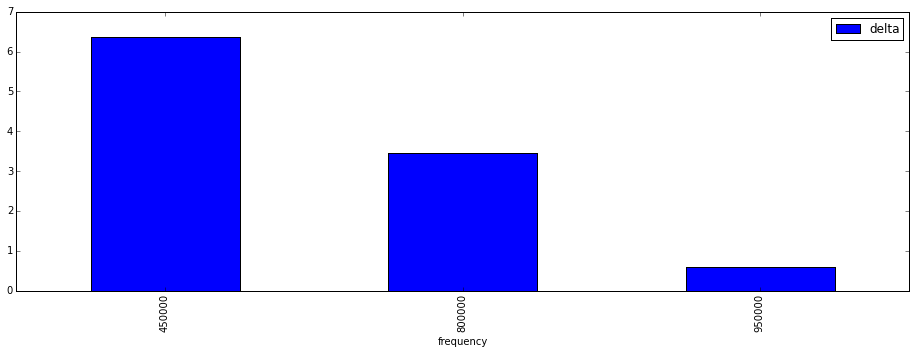

In [47]:
# Plot residency time
import matplotlib.pyplot as plt
# Enable generation of Notebook emebedded plots
%matplotlib inline

fig, axes = plt.subplots(1, 1, figsize=(16, 5));
df.plot(kind='bar', ax=axes);

# Example of Custom Plotting

In [31]:
from perf_analysis import PerfAnalysis

# Full analysis function
def analysis(t_min=None, t_max=None):
    test_dir = te.res_dir
    platform_json = '{}/platform.json'.format(test_dir)
    trace_file = '{}/trace.dat'.format(test_dir)
    
    # Load platform description data
    with open(platform_json, 'r') as fh:
        platform = json.load(fh)

    # Load RTApp Performance data
    pa = PerfAnalysis(test_dir)
    logging.info("Loaded performance data for tasks: %s", pa.tasks())
    
    # Load Trace data
    #events = my_tests_conf['ftrace']['events']
    events = [
            "sched_switch",
            "sched_contrib_scale_f",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_frequency",
            "cpu_capacity",
    ]
    trace = Trace(test_dir, events, platform)
    
    # Define time ranges for all the temporal plots
    trace.setXTimeRange(t_min, t_max)
    
    # Tasks performances plots
    for task in pa.tasks():
        pa.plotPerf(task)
    
    # Tasks plots
    trace.analysis.tasks.plotTasks(pa.tasks())

    # Cluster and CPUs plots
    trace.analysis.frequency.plotClusterFrequencies()

06:30:36  INFO    : Loaded performance data for tasks: ['task_lrh']
06:30:37  INFO    :   task         task_lrh found, pid: [1388]
06:30:37  INFO    : Collected events spans a 11.783 [s] time interval
06:30:37  INFO    : Set plots time range to (0.000000, 11.782671)[s]
06:30:37  INFO    : Set plots time range to (0.000000, 11.782671)[s]
06:30:37  INFO    : PerfIndex, Task [task_lrh] avg: 0.80, std: 0.12
06:30:38  INFO    :   task         task_lrh found, pid: [1388]
06:30:38  WARNING : Events [sched_overutilized] not found, plot DISABLED!
06:30:38  WARNING : Events [sched_overutilized] not found, plot DISABLED!
06:30:38  WARNING : Events [sched_overutilized] not found, plot DISABLED!
06:30:38  WARNING : Events [sched_overutilized] not found, plot DISABLED!
06:30:38  WARNING : Events [sched_overutilized] not found, plot DISABLED!
06:30:39  INFO    : LITTLE cluster average frequency: 0.595 GHz
06:30:39  INFO    : big    cluster average frequency: 0.628 GHz


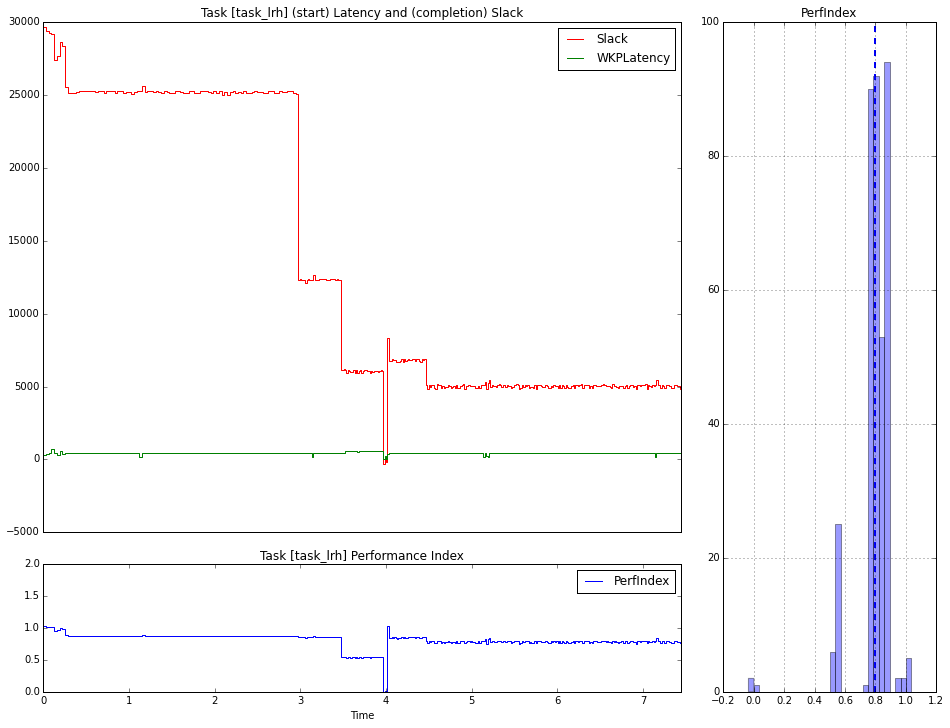

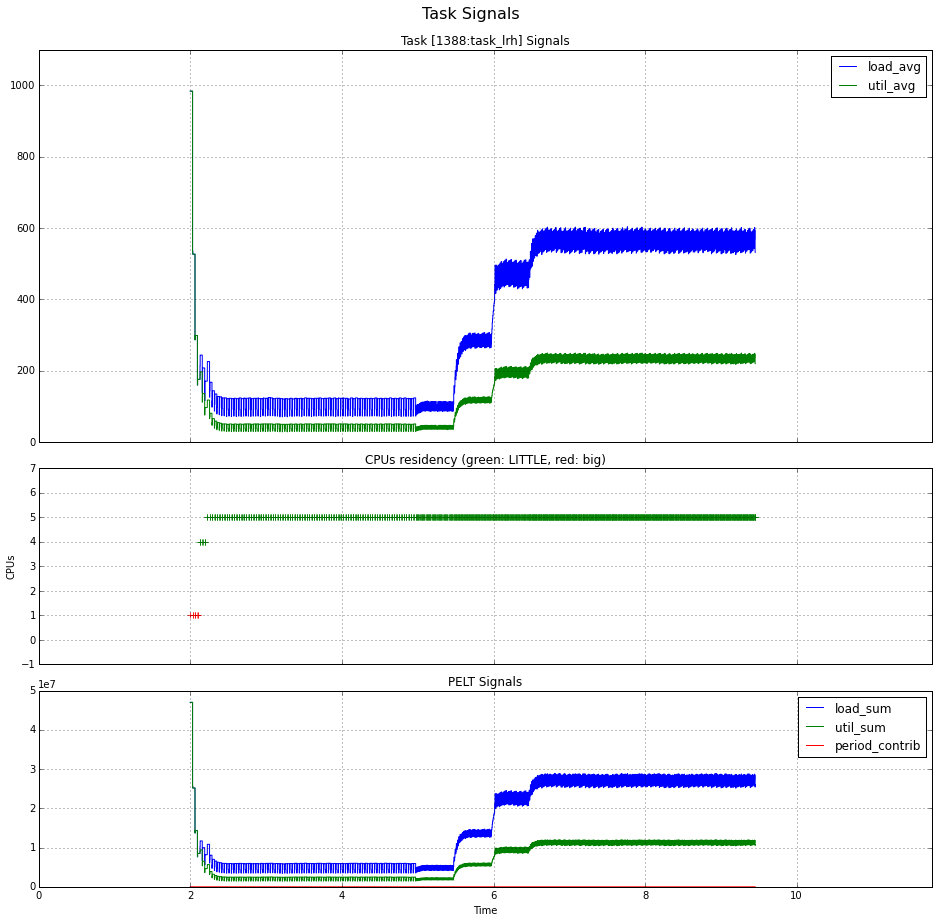

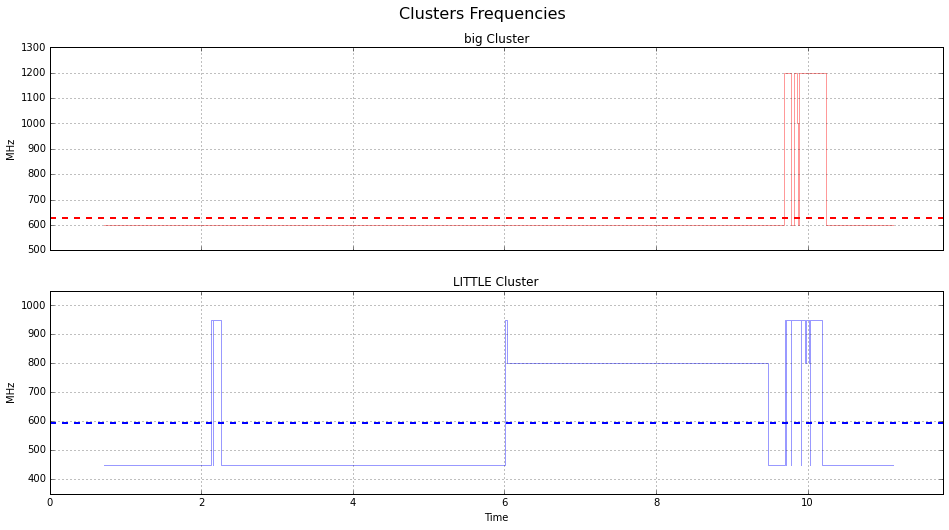

In [32]:
analysis()

<br><br><br><br>
Advanced TraceAnalysis and PerfAnalysis usage: use pre-defined functions to plot trace data and RTApp performance metrics<br>
[notebooks/tutorial/06_TraceAnalysis.ipynb](06_TraceAnalysis.ipynb)
<br>
[notebooks/tutorial/07_PerfAnalysis.ipynb](07_PerfAnalysis.ipynb)
<br><br><br><br>